In [1]:
%cd ../..

D:\myrepos\Audio_inpainting


## Conditioned-U-Net: Introducing a Control Mechanism in the U-Net for Multiple Source Separations

[0] Meseguer-Brocal, Gabriel, and Geoffroy Peeters. "CONDITIONED-U-NET: INTRODUCING A CONTROL MECHANISM IN THE U-NET FOR MULTIPLE SOURCE SEPARATIONS." Proceedings of the 20th International Society for Music Information Retrieval Conference. 2019.

### Abstract

Data-driven models for audio source separation such as U-Net or Wave-U-Net are usually models dedicated to and specifically **trained for a single task**, e.g. a **particular instrument isolation**. Training them for various tasks at once commonly results in worse performances than training them for a single specialized task. In this work, we introduce the **Conditioned-U-Net (C-U-Net)** which adds a **control mechanism** to the standard **U-Net**. The control mechanism allows us to train a unique and generic U-Net to perform the separation of various instruments. The C-U-Net decides the instrument to isolate according to a one-hot-encoding input vector. The input vector is embedded to obtain the parameters that control **Feature-wise Linear Modulation (FiLM)** layers. FiLM layers modify the U-Net feature maps in order to separate the desired instrument via affine transformations. The C-U-Net performs different instrument separations, all with a single model achieving the same performances as the dedicated ones at a lower cost.

### 1. Background

#### 1.1. TFC_TDF_Net:  An Example of Typical U-Nets for Music Source Separation

In this section, we indroduce an example of 'U-Nets which are dedicated to and specifically trained for a single task', named TFC_TDF_Net.
The TFC_TDF_Net is a U-Net-like architecture that tries to extract the singing voice from a given input mixture signal.
It takes a $c$-channeled mixture signal and outputs a $c$-channeled singing voice signal. It consists of three parts as follows:

![](imgs/cac.png)

##### 1.1.a. The Spectrogram Extraction Layer 
It extracts a mixture spectrogram by applying STFT (see [Fourier part. 1](https://github.com/Intelligence-Engineering-LAB-KU/Seminar/blob/master/summer_2020/0721_wschoi_Fourier_anlysis_Part1.ipynb) and [Fourier part. 2](https://github.com/Intelligence-Engineering-LAB-KU/Seminar/blob/master/summer_2020/0721_wschoi_Fourier_analysis_Part2.ipynb) for details)  to the $c$-channeled input signal. The output of STFT is a complex-valued spectrogram with $c$-channels. Considering the imaginary and real parts as separate real-valued channels, we view the mixture spectrogram $M_{complex} \in \mathbb{C} ^{c \times T \times F}$ as a $(2c)$-channeled real-valued spectrogram $M \in \mathbb{R} ^{ \left(2c\right) \times T \times F}$, where $T$ denotes the number of frames and $F$ denotes the number of the frequency bins in the spectrogram. 

In [13]:
from ielab_audio.data.musdb_wrapper import DataProvider
import IPython.display as ipd

dataset = FiledMusdbValidSet(musdb_root='../data/musdb18_wav', n_fft=2048, hop_length=1024, num_frame=128, target_names=['vocals'])
mixture, _, _, _, target_name, singing_voice = dataset[50]

print('mixture shape:{}, target_name:{}, singing_voice shape:{}'.format(mixture.shape, target_name, singing_voice.shape))
ipd.Audio(mixture.detach().numpy().T, rate=44100)

D:\myrepos\Audio_inpainting\ielab_audio\data\musdb_wrapper\preprocessed_datasets.py:132: UserWarning: Librosa Musdbset does not need to be cached.
  warn('Librosa Musdbset does not need to be cached.')


mixture shape:torch.Size([130048, 2]), target_name:vocals, singing_voice shape:torch.Size([130048, 2])


mixture shape:torch.Size([130048, 2])
M_complex shape:torch.Size([1025, 128, 2, 2])


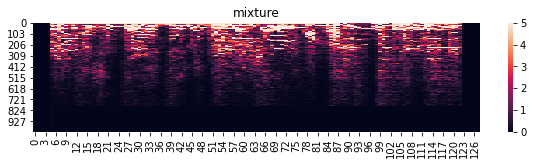

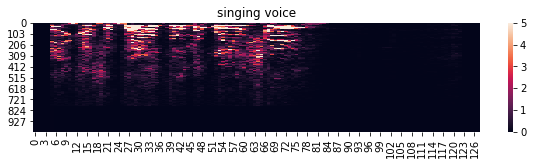

In [3]:
from ielab_audio.utils.fourier import multi_channeled_STFT

stft = multi_channeled_STFT(n_fft=2048, hop_length=1024)
M_complex = stft.to_spec_complex(mixture)

print('mixture shape:{}\nM_complex shape:{}'.format(mixture.shape, M_complex.shape))

M_mag = stft.to_mag(mixture)
T_mag = stft.to_mag(singing_voice)

import seaborn
import matplotlib.pyplot as plt
plt.figure(figsize=(10,2))
plt.title('mixture')
seaborn.heatmap(M_mag[:,:,0].detach().numpy(), vmax=5)
plt.show()
plt.figure(figsize=(10,2))
plt.title('singing voice')
seaborn.heatmap(T_mag[:,:,0].detach().numpy(), vmax=5)
plt.show()

##### 1.1.b. The complex-valued spectrogram estimation network
It is a  neural network that takes the spectrogram $\mathbf{M}$ of a mixture signal as input and estimates the target spectrogram $\hat{T} \in \mathbb{R} ^{\; \left(2c\right) \times T \times F}$, which is used for reconstructing the vocal signal later.

It can also be viewed as an **encoder-decoder network**. 

![](imgs/unet.png)

The TFC_TDF_Net uses [TFC_TDF](https://github.com/ws-choi/ISMIR2020_U_Nets_SVS/blob/master/paper_with_code/Paper%20with%20Code%20-%203.%20INTERMEDIATE%20BLOCKS.ipynb) blocks for intermediate blocks

<AxesSubplot:title={'center':'estmated singing voice (not trained)'}>

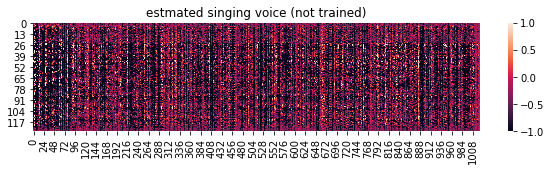

In [4]:
from ielab_audio.models.one2one_separation import TFC_TDF_NET_Framework

params = {'n_blocks':3, 'input_channels':4, 'internal_channels':4, 'n_internal_layers':3, 
          'first_conv_activation':'relu', 'last_activation':'identity',            
          't_down_layers':None, 'f_down_layers':None,
          'kernel_size_f':3, 'kernel_size_t':3,
          'bn_factor':16, 'min_bn_units':16, 'tfc_tdf_bias':False, 
          'tfc_tdf_activation':'relu',
          'tif_init_mode':None}

tfc_tdf_net = TFC_TDF_NET_Framework(
    target_name='vocals',
    n_fft=2048, hop_length=1024, num_frame=128,
    spec_type='complex', spec_est_mode='mapping',
    optimizer='rmsprop', lr=0.001, dev_mode=False,
    train_loss='ncs_44100', val_loss='nsdr_44100',
    layer_level_init_weight=True,
    unfreeze_stft_from=-1,
    **params
)

input_spec = tfc_tdf_net.to_spec(mixture.unsqueeze(0))
output_spec = tfc_tdf_net.spec2spec(input_spec).squeeze(0)

plt.figure(figsize=(10,2))
plt.title('estmated singing voice (not trained)')
seaborn.heatmap(output_spec.cpu()[0].detach().numpy(), vmin=-1, vmax=1)



##### 1.1.c. The signal reconstruction layer
It reshapes the estimated spectrogram $\hat{T}$ into the complex-valued spectrogram  $\hat{T}_{complex} \in \mathbb{C} ^{\; c \times T \times F}$, as shown in Figure \ref{fig:cac}. It then restores the estimated singing voice signal via inverse-STFT on $\hat{T}_{complex}$.

In [5]:
output_spec = output_spec.transpose(-1, -3)
output_spec = output_spec.view(list(output_spec.shape)[:-1] + [2, -1])
restored = stft.restore_complex(output_spec).cpu().detach().numpy()
ipd.Audio(restored.T, rate=44100)

#### 1.2. How to train TFC_TDF_Net?

Below is the conceptual code for training TFC_TDF_Net, which is not the same as our implementation.

```python

def training_step(self, batch, batch_idx):
    mixture_signal, target_signal, _ = batch

    # target spectrogram estimation
    M_complex = model.to_spec(mixture_signal)
    T_complex_hat = model.spec2spec(M_complex)
    
    # ground-truth target spectrogram
    T_complex = model.to_spec(target_signal)

    loss = self.criterion(T_complex_hat, T_complex)
    
    # for pytorch-lightning
    result = pl.TrainResult(loss)
    result.log('train_loss', loss, prog_bar=False, logger=True, on_step=False, on_epoch=True,
               reduce_fx=torch.mean)
    return result
        
```

In [26]:
import  pytorch_lightning as pl
from ielab_audio.data.musdb_wrapper import DataProvider
data_provider = DataProvider(musdb_root='../data/musdb18_wav', musdb_is_wav=True, filed_mode=True,
                             target_names=['vocals'], batch_size=64, pin_memory=True, num_workers=8,
                             dev_mode=False, one_hot_mode=False)
trainer = pl.Trainer(logger=False, checkpoint_callback=False, early_stop_callback=False, gpus=1, precision=16,
                    max_epochs=5, val_percent_check = 0)
train_dataloader = data_provider.get_train_dataloader(n_fft=2048, hop_length=1024, num_frame=128)

pl.seed_everything(2020)
tfc_tdf_net.init_weights()
trainer.fit(tfc_tdf_net, train_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name      | Type                 | Params
---------------------------------------------------
0 | stft      | multi_channeled_STFT | 2 K   
1 | spec2spec | TFC_TDF_NET          | 298 K 


Saving latest checkpoint..


1

#### 1.3. After few epochs

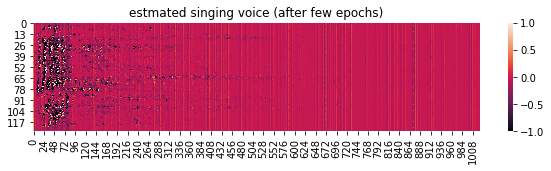

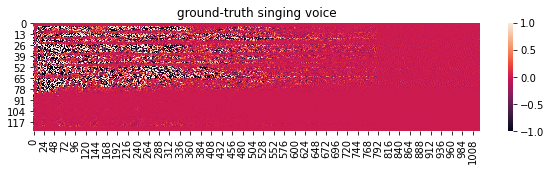

In [31]:
tfc_tdf_net.eval()
input_spec = tfc_tdf_net.to_spec(mixture.unsqueeze(0))
output_spec = tfc_tdf_net.spec2spec(input_spec).squeeze(0)

plt.figure(figsize=(10,2))
plt.title('estmated singing voice (after few epochs)')
seaborn.heatmap(output_spec.cpu()[0].detach().numpy(), vmin=-1, vmax=1)

plt.figure(figsize=(10,2))
plt.title('ground-truth singing voice')
target_spec = tfc_tdf_net.to_spec(singing_voice)
seaborn.heatmap(target_spec.cpu()[0].detach().numpy(), vmin=-1, vmax=1)

output_spec = output_spec.transpose(-1, -3)
output_spec = output_spec.view(list(output_spec.shape)[:-1] + [2, -1])
restored = stft.restore_complex(output_spec).cpu().detach().numpy()
ipd.Audio(restored.T, rate=44100)

In [32]:
print(tfc_tdf_net)

TFC_TDF_NET_Framework(
  (stft): multi_channeled_STFT(
    (stft): STFT()
  )
  (spec2spec): TFC_TDF_NET(
    (first_conv): Sequential(
      (0): Conv2d(4, 4, kernel_size=(1, 2), stride=(1, 1))
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (encoders): ModuleList(
      (0): TFC_TIF(
        (tfc): TFC(
          (H): ModuleList(
            (0): Sequential(
              (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
            (1): Sequential(
              (0): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
            (2): Sequential(
              (0): Conv2d(12, 4, kernel_size=(3, 3), stride=(1, 1),

#### 1.4. More Information about TFC_TDF_Net

[1] Woosung Choi, Minseok Kim, Jaehwa Chung, Daewon Lee, and Soonyoung Jung, "Investigating U-NETS With Various Intermediate Blocks For Spectrogram-based Singing Voice Separation", ISMIR 2020

[2] Woosung Choi, Minseok Kim, Jaehwa Chung, Daewon Lee, and Soonyoung Jung. "[Investigating Deep Neural Transformations for Spectrogram-based Musical Source Separation](https://arxiv.org/abs/1912.02591)" arXiv preprint arXiv:1912.02591 (2019).

[3] Github link: https://github.com/ws-choi/ISMIR2020_U_Nets_SVS

### 2. Motivation of Conditioned U-Net

![](https://imgur.com/2s7l5O0.png)

Figure from [0]: Traditional Approach VS Conditioned-U-Net

```
This control mechanism permits multiple instrument source separations with a single model without losing any performance.
It is motivated by the idea that we can process the same input differently depending of some external context.
```

### 3. Core Idea

See more details from this link https://github.com/gabolsgabs/cunet

![](https://github.com/gabolsgabs/cunet/raw/master/.markdown_images/overview.png)


#### 3.0. Overview

```

two core elements:

- **Generic model**: not specialized in any particular task, but rather in finding a set of generic source separation tools.
- **Control**: that defines how to combine the set of tools.
```

![](https://imgur.com/3fYhGAi.png)

#### 3.1. Generic model

```
The generic model is a U-Net[3] and it has to main part:
- **The decoder** codifies and highlights the relevant information to separate a particular instrument creating a latent space.
- **The encoder** transforms the latent space back to audio signal.

It is important to decide where to condition. And we think that it is essential to be able to create **different latent spaces per instrument**. Therefore, we condition **only the decoder**.

**FiLM layers[4]** are applied at each encoder block after batch normalization.
```

#### 3.2. Condition generator

```
The condition generator takes as input a vector with the desired instrument to separate and compute the gammas and betas that control the generic model. We test two different configurations based on fully-connected architecture and convolutional one.  

Both systems are trained jointly.

```

##### 3.2.a. Control Model

```python
class dense_control_model(pl.LightningModule):
    def __init__(self, dense_control_block, output_features, split,
                 gamma_activation=nn.Identity, beta_activation=nn.Identity):
        super(dense_control_model, self).__init__()
        self.dense_control_block = dense_control_block
        self.split = split
        self.gamma_activation = gamma_activation()
        self.beta_activation = beta_activation()

        self.linear_gamma = nn.Sequential(
            nn.Linear(dense_control_block.last_dim, output_features),
            self.gamma_activation
        )
        self.linear_beta = nn.Sequential(
            nn.Linear(dense_control_block.last_dim, output_features),
            self.beta_activation
        )

    def forward(self, x):
        # x is a one-hot encoded vector
        x = self.dense_control_block(x) 
        # x is a latent space vector that encodes one-hot encoded condition
        
        # we split the output to distribute it into each encoding layer.  
        return self.split(self.linear_gamma(x)), self.split(self.linear_beta(x))

```
##### 3.2.b. FiLM Layer

```
FiLM permits to modulate any neural network architecture inserting one or several FiLM layers at any depth of the original model [4]:
```

- $ FiLM(x) = \gamma(z) \cdot x + \beta(z) $

```
x is the input of the FiLM layer and gamma and beta the learnable parameters that scale and shift x based on an external information, z.

The original FiLM computes a different operation per features map, and we propose a new layer that performs the same affine operation to the whole input.
```

![](https://github.com/gabolsgabs/cunet/raw/master/.markdown_images/FiLM_layers.png)


Below is an implementation of FiLM operation:

```python
def FiLM_simple(x, gamma, beta):
    """
    :param x: an output feature map of a CNN layer [*, ch, T, F]
    :param gamma: [*, 1]
    :param beta: [*, 1]
    :return: gamma * x + beta
    """
    gamma_ = gamma.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
    beta_ = beta.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
    return gamma_ * x + beta_


def FiLM_complex(x, gammas, betas):
    """
    :param x: an output feature map of a CNN layer [*, ch, T, F]
    :param gamma: [*, ch]
    :param beta: [*, ch]
    :return: gamma * x + beta
    """
    gamma_ = gammas.unsqueeze(-1).unsqueeze(-1)
    beta_ = betas.unsqueeze(-1).unsqueeze(-1)
    return gamma_ * x + beta_
```


##### 3.2.c. (Merge) Encoding Layers of Conditioned-U-Net

```python
import torch.nn as nn
from ielab_audio.models.building_blocks import TIF, TFC
from ielab_audio.utils.weight_initialization import WI_Module

class cu_net_conv_block(WI_Module):
    def __init__(self, conv_layer, bn_layer, film_layer, activation):
        super(cu_net_conv_block, self).__init__()
        self.bn_layer = bn_layer
        self.conv_layer = conv_layer
        self.FiLM_layer = film_layer
        self.activation = activation
        self.in_channels = self.conv_layer.conv.in_channels
        self.out_channels = self.conv_layer.conv.out_channels

    def forward(self, x, gamma, beta):
        x = self.bn_layer(self.conv_layer(x))
        x = self.FiLM_layer(x, gamma, beta)
        return self.activation(x)

```

[3] *A.Jansson, N.Montecchio, R.Bittner, A.Kumar, T.Weyde, E. J. Humphrey. Singing voice separation with deep u-net convolutional networks. In Proc. of ISMIR (International Society for Music Information Retrieval), Suzhou, China, 2017.*

[4] *E. Perez, F. Strub, H. de Vries, V. Dumoulin, and A. C. Courville. Film: Visual reasoning with a general condition- ing layer. In Proc. of AAAI (Conference on Artificial Intelligence), New Orleans, LA, USA, 2018.*

### 4. Implemantation

```python
class CUNET(nn.Module):

    def __init__(self,
                 n_layers,
                 input_channels,
                 filters_layer_1,
                 kernel_size=(5, 5),
                 stride=(2, 2),
                 film_type='simple',
                 control_type='dense',
                 encoder_activation=nn.LeakyReLU,
                 decoder_activation=nn.ReLU,
                 last_activation=nn.Sigmoid,
                 control_input_dim=4,
                 control_n_layer=4
                 ):

        encoder_activation = get_activation_by_name(encoder_activation)
        decoder_activation = get_activation_by_name(decoder_activation)
        self.last_activation = last_activation = get_activation_by_name(last_activation)

        super(CUNET, self).__init__()

        self.input_control_dims = control_input_dim
        self.n_layers = n_layers
        self.input_channels = input_channels
        self.filters_layer_1 = filters_layer_1

        # Encoder
        encoders = []
        for i in range(n_layers):
            output_channels = filters_layer_1 * (2 ** i)
            encoders.append(
                cu_net_conv_block(
                    conv_layer=Conv2d_same(input_channels, output_channels, kernel_size, stride),
                    bn_layer=nn.BatchNorm2d(output_channels),
                    film_layer=FiLM_simple if film_type == "simple" else FiLM_complex,
                    activation=encoder_activation()
                )
            )
            input_channels = output_channels
        self.encoders = nn.ModuleList(encoders)

        # Decoder
        decoders = []
        for i in range(n_layers):
            # parameters each decoder layer
            is_final_block = i == n_layers - 1  # the las layer is different
            # not dropout in the first block and the last two encoder blocks
            dropout = not (i == 0 or i == n_layers - 1 or i == n_layers - 2)
            # for getting the number of filters
            encoder_layer = self.encoders[n_layers - i - 1]
            skip = i > 0  # not skip in the first encoder block

            input_channels = encoder_layer.out_channels
            if skip:
                input_channels *= 2

            if is_final_block:
                output_channels = self.input_channels
                activation = last_activation
            else:
                output_channels = encoder_layer.in_channels
                activation = decoder_activation

            decoders.append(
                u_net_deconv_block(
                    deconv_layer=ConvTranspose2d_same(input_channels, output_channels, kernel_size, stride),
                    bn_layer=nn.BatchNorm2d(output_channels),
                    activation=activation(),
                    dropout=dropout
                )
            )

            self.decoders = nn.ModuleList(decoders)

        # Control Mechanism
        if film_type == "simple":
            control_output_dim = n_layers

            def split_simple(tensor):
                return [tensor[..., layer] for layer in range(n_layers)]

            split = split_simple

        else:
            output_channel_array = [encoder.conv_layer.conv.out_channels for encoder in self.encoders]
            control_output_dim = sum(output_channel_array)

            start_idx_per_layer = [sum(output_channel_array[:i]) for i in range(len(output_channel_array))]
            end_idx_per_layer = [sum(output_channel_array[:i + 1]) for i in range(len(output_channel_array))]

            def split_complex(tensor):
                return [tensor[..., start:end] for start, end in
                        zip(start_idx_per_layer, end_idx_per_layer)]

            split = split_complex

        if control_type == "dense":
            self.condition_generator = dense_control_model(
                dense_control_block(control_input_dim, control_n_layer),
                control_output_dim,
                split
            )
        else:
            raise NotImplementedError

    def init_weights(self):
        for sub_module in self.encoders:
            sub_module.init_weights()
        for sub_module in self.decoders:
            sub_module.init_weights()
        self.condition_generator.init_weights()

    def forward(self, input_spec, input_condition):

        gammas, betas = self.condition_generator(input_condition)

        x = input_spec

        # Encoding Phase
        encoder_outputs = []
        for encoder, gamma, beta in zip(self.encoders, gammas, betas):
            encoder_outputs.append(encoder(x, gamma, beta))  # TODO
            x = encoder_outputs[-1]

        # Decoding Phase
        x = self.decoders[0](x)
        for decoder, x_encoded in zip(self.decoders[1:], reversed(encoder_outputs[:-1])):
            x = decoder(torch.cat([x, x_encoded], dim=-3))

        return x
```

![](https://imgur.com/3fYhGAi.png)

### 5. Evaluation

might need to be improved :(


#### 5.1 Original Paper
![](https://imgur.com/helrVQj.png)
#### Our implementation

|Name                     |control_input_dim|control_n_layer|control_type|decoder_activation|encoder_activation|film_type|filters_layer_1|hop_length|input_channels|kernel_size|last_activation|lr   |n_fft|n_layers|num_frame|optimizer|stride|test_result/agg/bass_ISR|test_result/agg/bass_SAR|test_result/agg/bass_SDR|test_result/agg/bass_SIR|test_result/agg/drums_ISR|test_result/agg/drums_SAR|test_result/agg/drums_SDR|test_result/agg/drums_SIR|test_result/agg/other_ISR|test_result/agg/other_SAR|test_result/agg/other_SDR|test_result/agg/other_SIR|test_result/agg/vocals_ISR|test_result/agg/vocals_SAR|test_result/agg/vocals_SDR|test_result/agg/vocals_SIR|
|-------------------------|-----------------|---------------|------------|------------------|------------------|---------|---------------|----------|--------------|-----------|---------------|-----|-----|--------|---------|---------|------|------------------------|------------------------|------------------------|------------------------|-------------------------|-------------------------|-------------------------|-------------------------|-------------------------|-------------------------|-------------------------|-------------------------|--------------------------|--------------------------|--------------------------|--------------------------|
|complex_2048_512_128eval |4                |4              |dense       |relu              |leaky_relu        |complex  |24             |512       |2             |[5,5]      |sigmoid        |0.001|2048 |6       |128      |adam     |[2,2] |8.84835                 |4.81325                 |2.795465                |4.114615                |9.69044                  |4.2979225                |3.492365                 |4.63526                  |6.93455                  |3.87871                  |1.85376                  |1.0855625                |6.0647475                 |2.2080925                 |2.49749                   |8.3487875                 |
|complex_32eval_          |4                |4              |dense       |relu              |leaky_relu        |complex  |32             |256       |2             |[5,5]      |sigmoid        |0.001|1024 |6       |256      |adam     |[2,2] |8.0865575               |4.79529                 |2.1145975               |2.6459025               |10.019905                |4.9158075                |3.795275                 |4.92333                  |7.5122025                |4.58683                  |1.705415                 |1.07406                  |7.470695                  |3.63371                   |2.415865                  |6.5487125                 |
|cunet_mme_sigmoid_32-eval|4                |4              |dense       |relu              |leaky_relu        |simple   |32             |256       |2             |[5,5]      |sigmoid        |0.001|1024 |6       |256      |adam     |[2,2] |7.6462525               |4.90194                 |1.84956                 |1.9313625               |9.4997225                |4.6694725                |3.327125                 |4.113235                 |7.648405                 |4.659825                 |1.500495                 |0.5541025                |6.710985                  |3.602105                  |2.12235                   |5.72728                   |


### 7. Discussion

- Author's Assumptions
    - This control mechanism permits multiple instrument source separations with a single model without **losing any performance**.
    - It is important to decide where to condition. And we think that it is essential to be able to create **different latent spaces per instrument**. Therefore, we condition **only the decoder**.    
    - Spectrogram-independent Modulation VS Modulation that both considers input conditions and spectrograms
        - The C-U-net is more likely a two-streamed model.
    - One-hot encoding input vector

- Room for improvement
    - [TFC_TDF_CUnet-complex](https://app.wandb.ai/wschoi/round_1?workspace=user-wschoi)
    - [TFC_TDF_CUnet-simple](https://app.wandb.ai/wschoi/source_separation?workspace=user-wschoi)